In [113]:
from lightkurve import search_lightcurve, LightCurveCollection
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'
%matplotlib inline

from lightkurve.correctors import CBVCorrector

In [125]:
kepid = '4997179'

lcs = search_lightcurve('KIC ' + kepid, cadence='long').download_all(flux_column='sap_flux')

cbvCorrector = []

[cbvCorrector.append(CBVCorrector(lcs[i])) for i in range(len(lcs))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

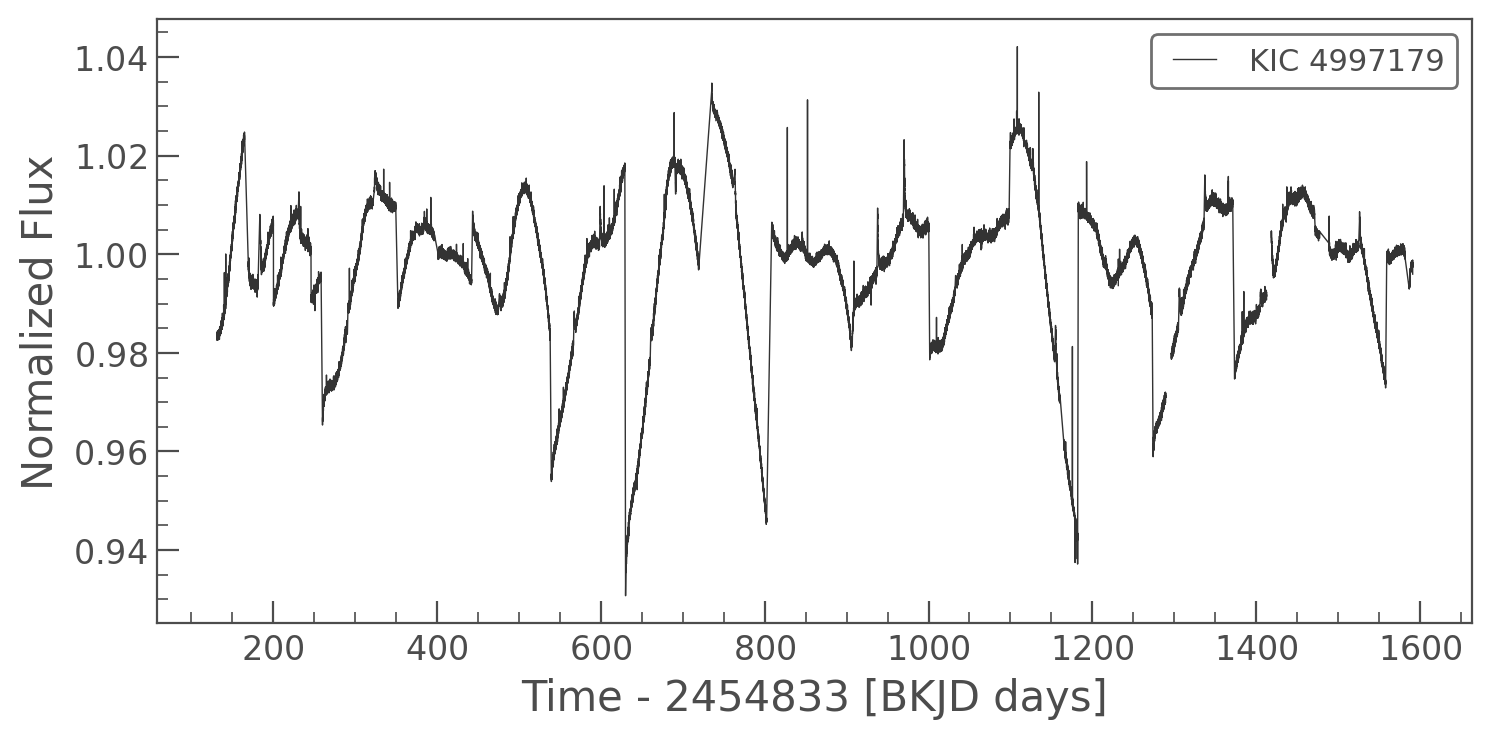

In [126]:
lc = lcs.stitch()

lc.plot()

0


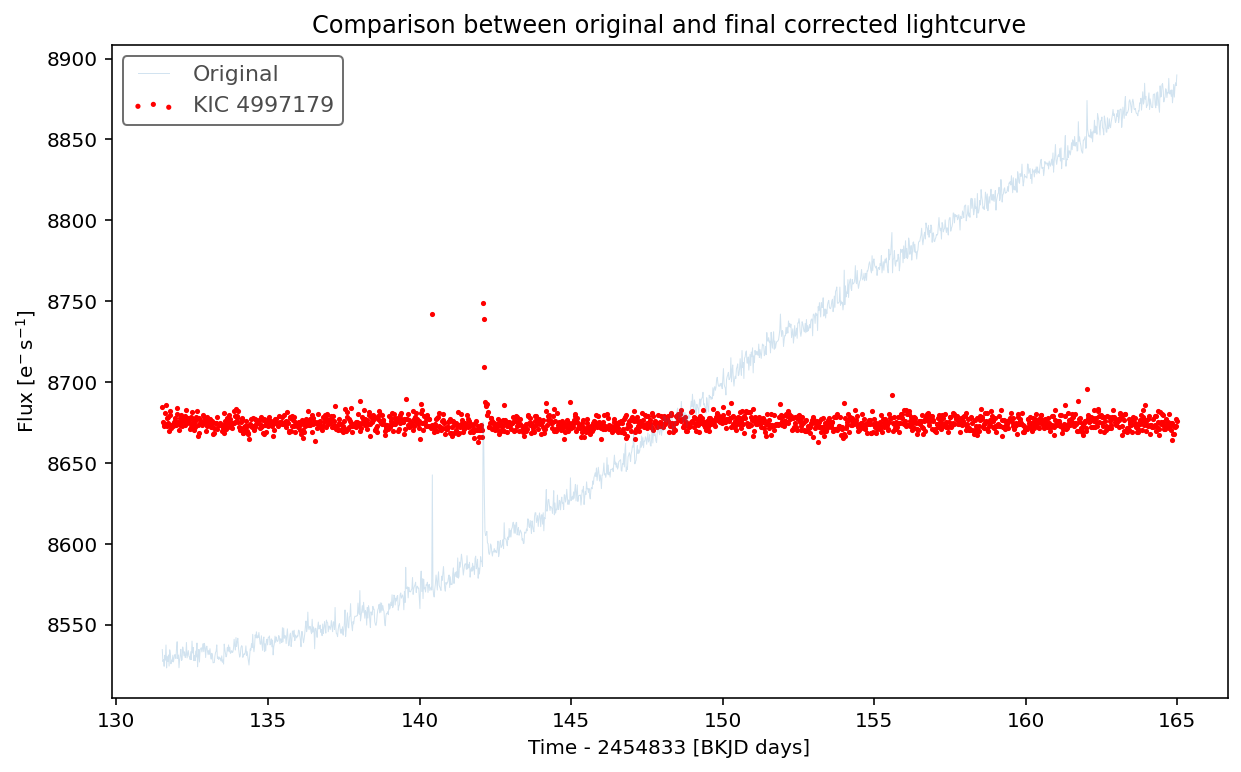

1


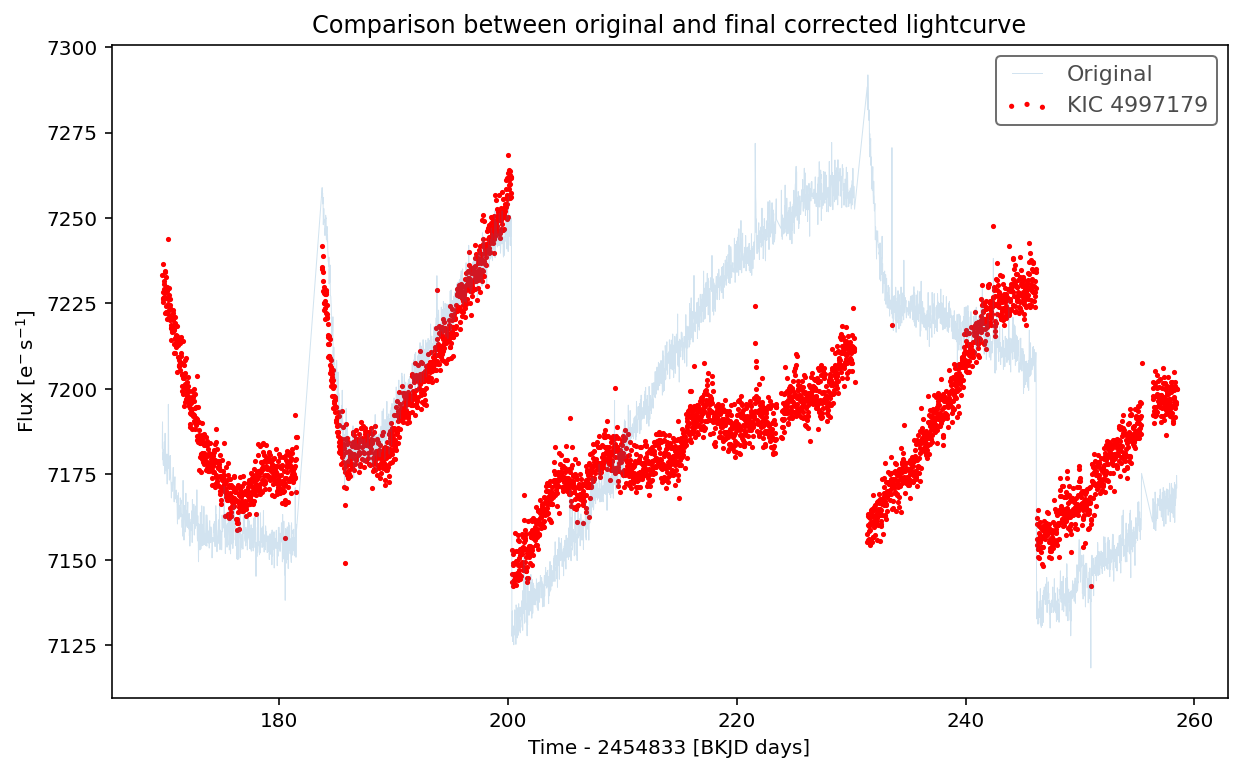

2


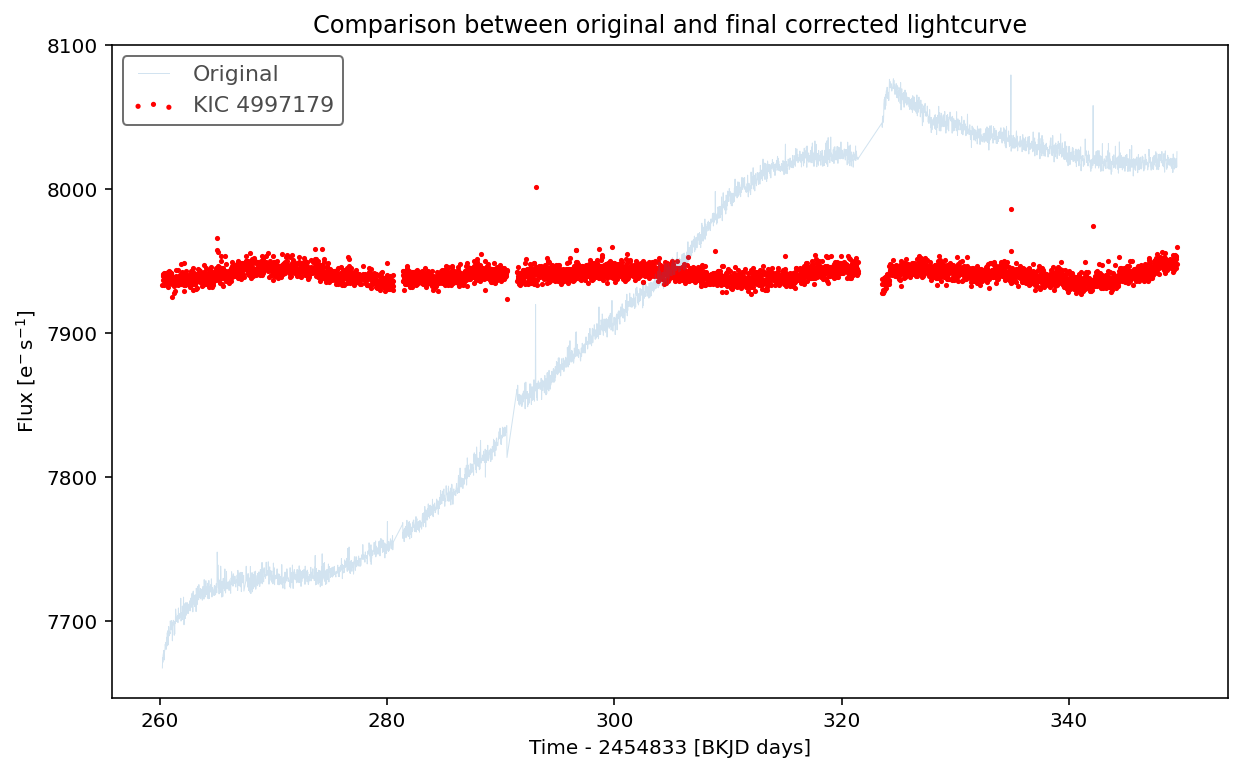

3


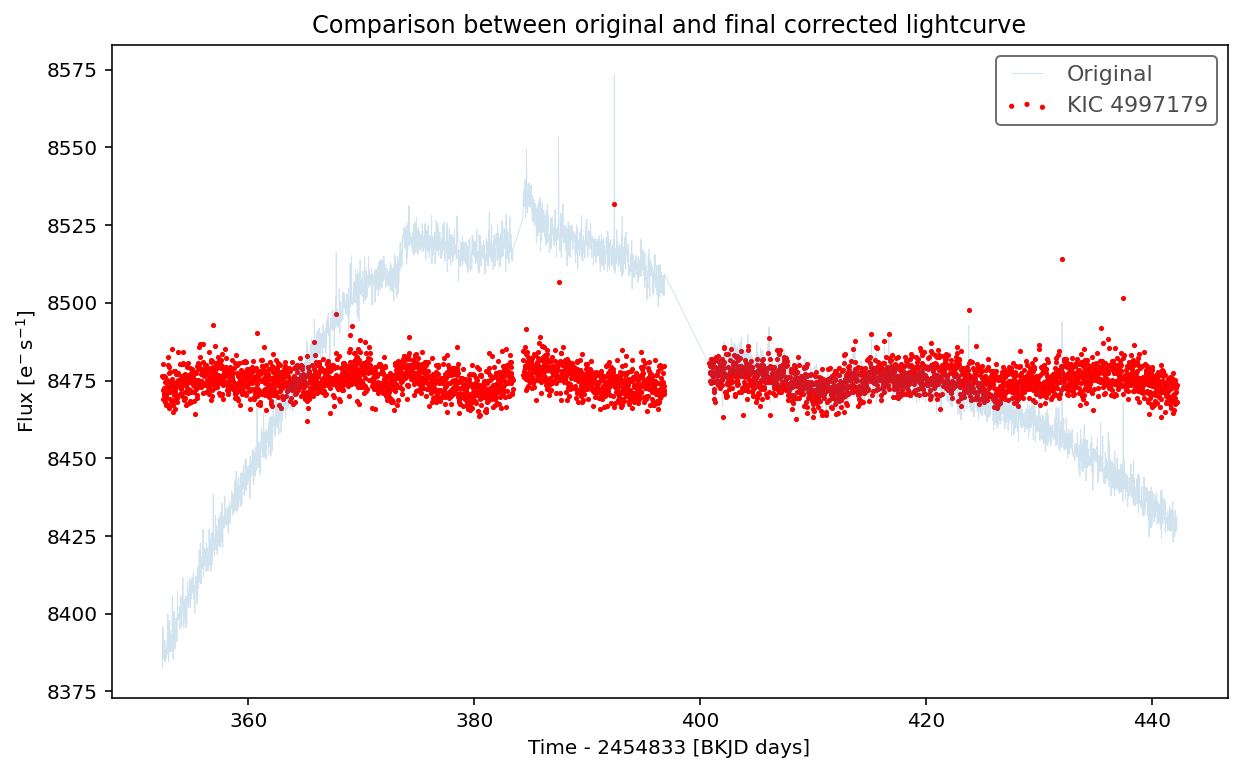

4


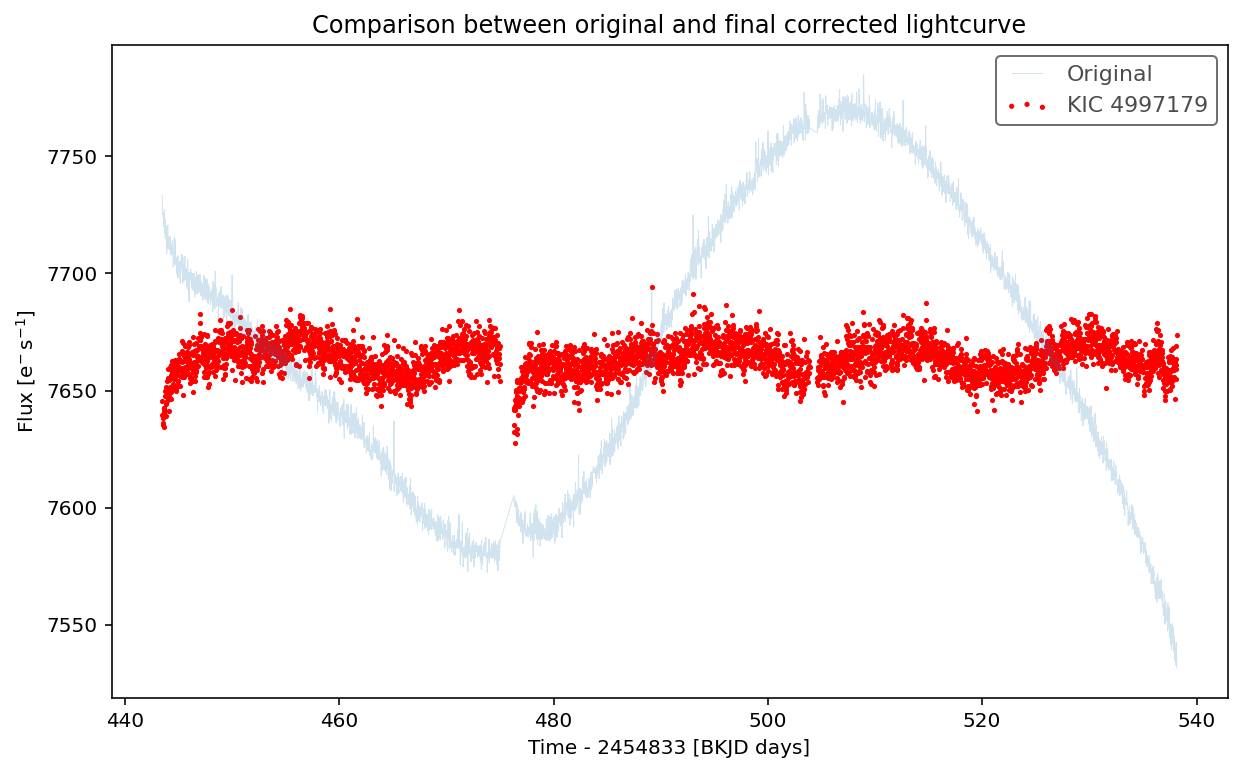

5


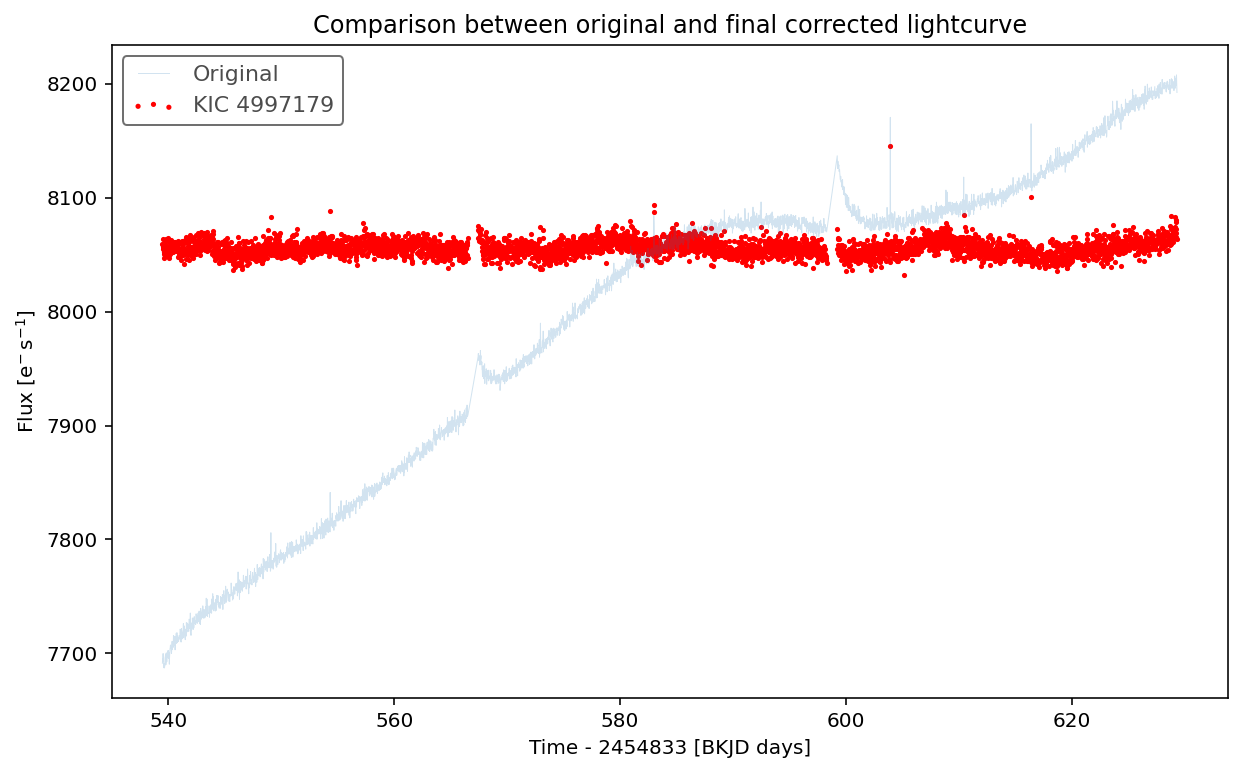

6


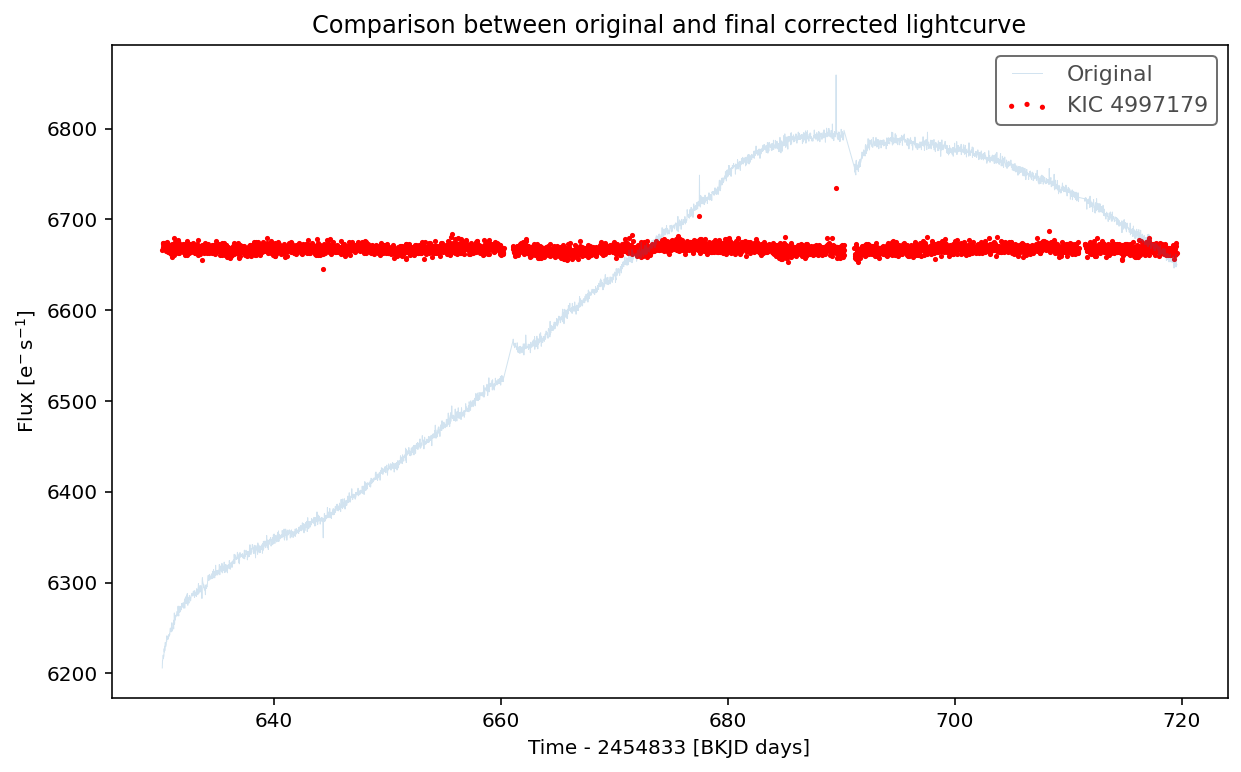

7


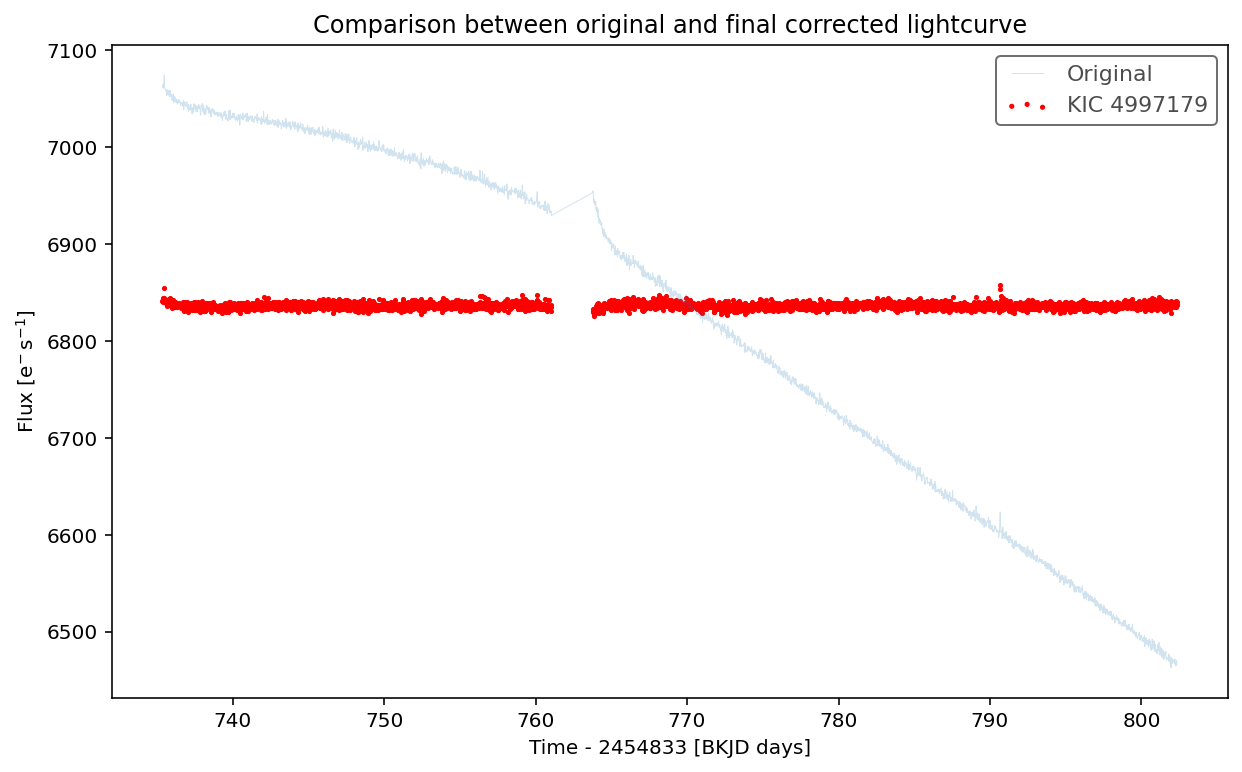

8


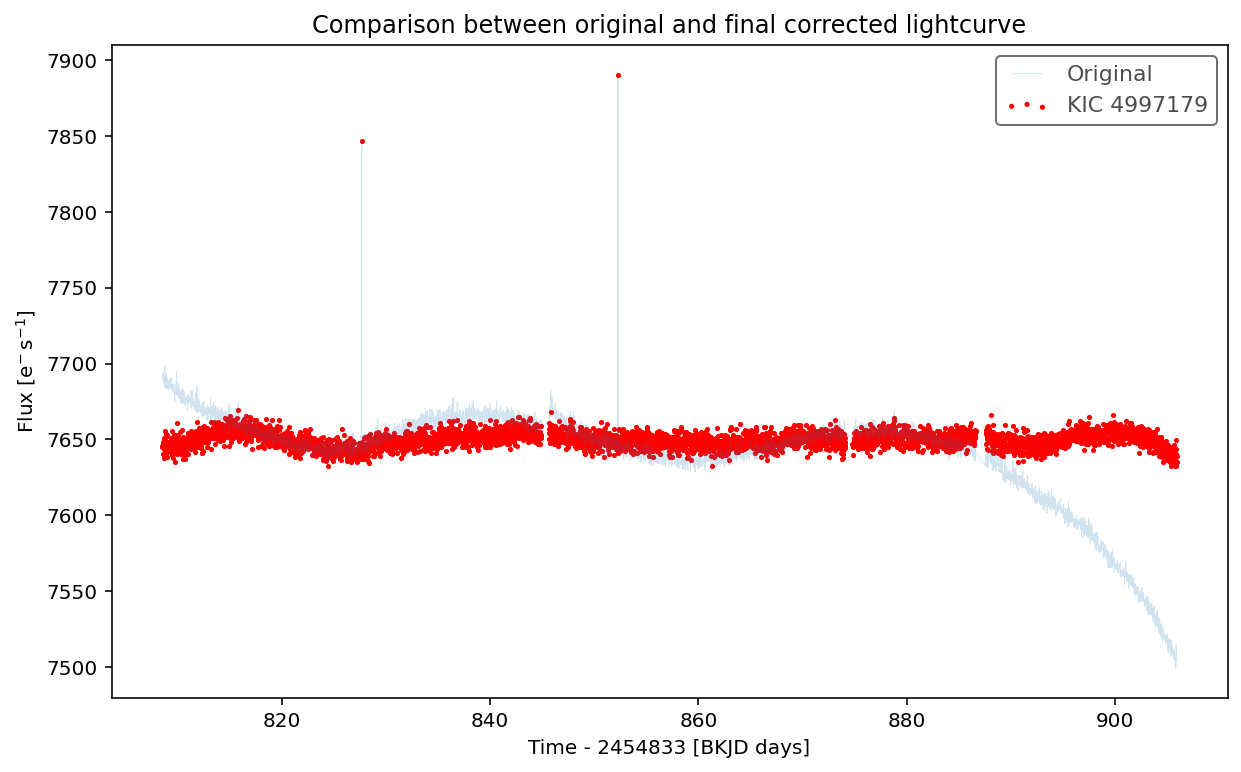

9


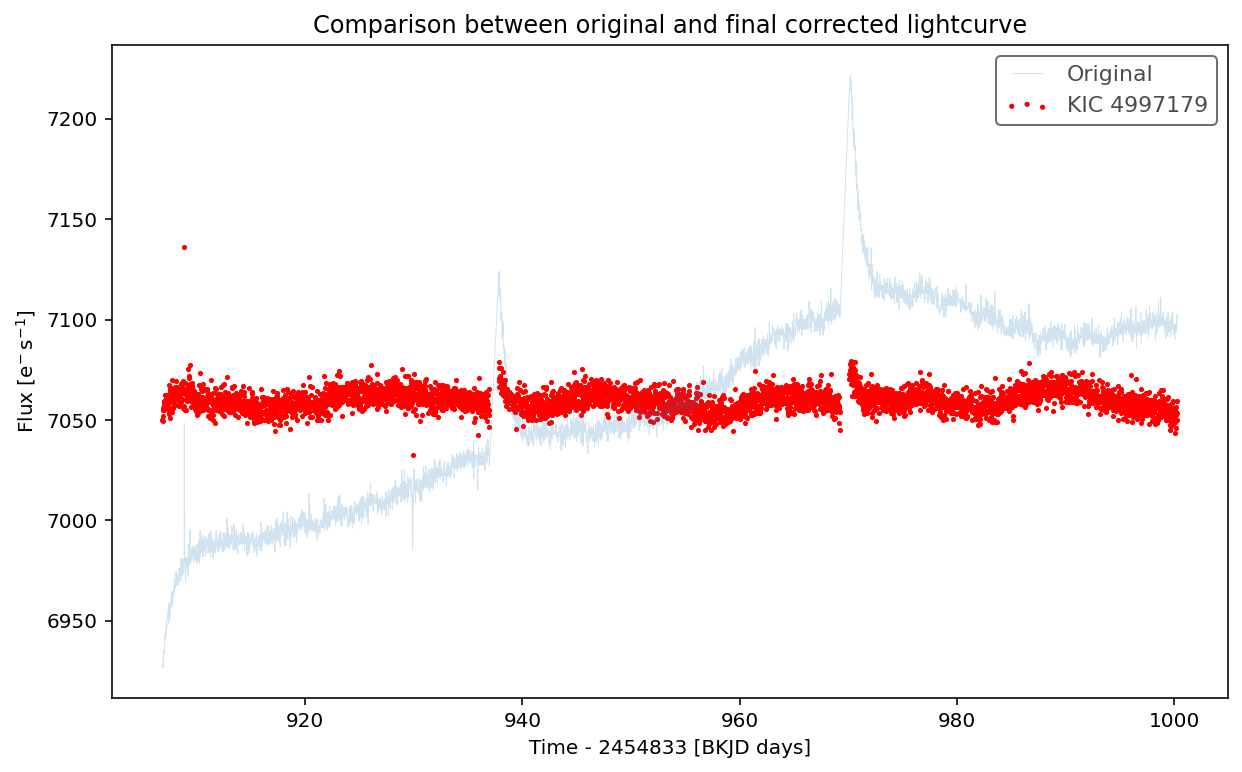

10


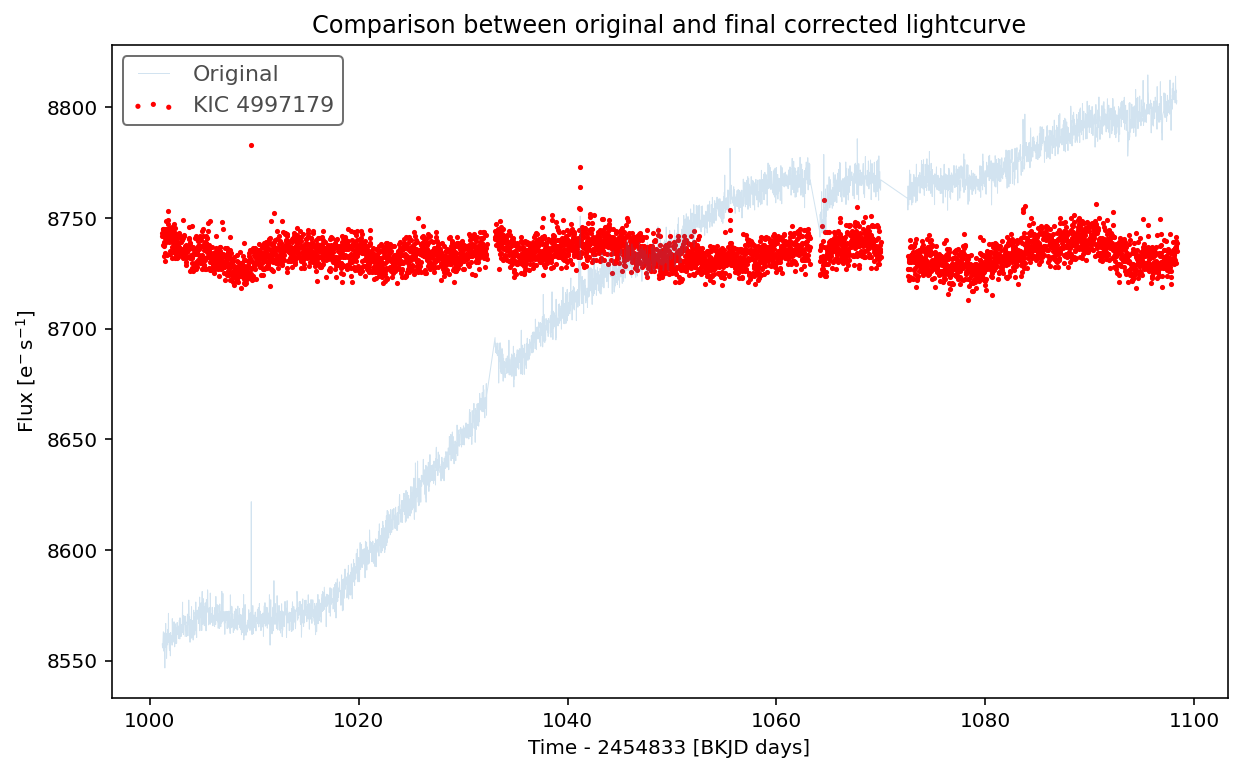

11


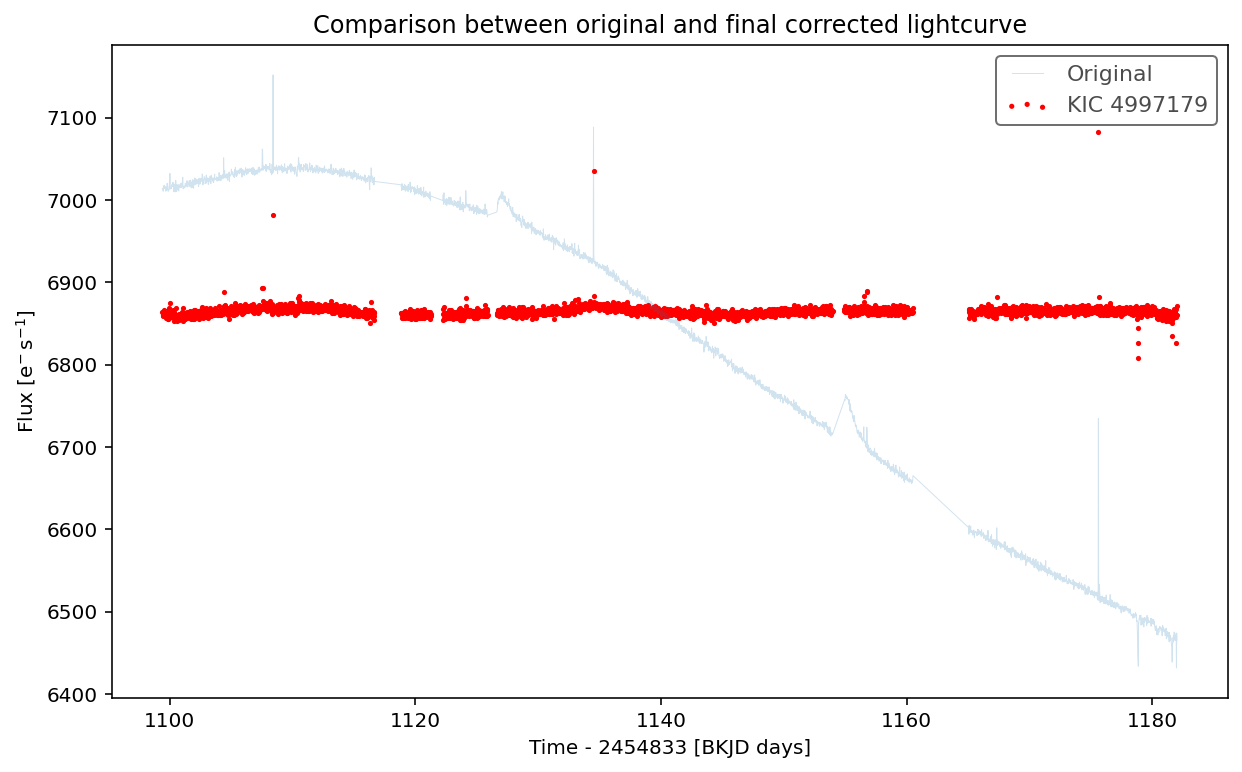

12


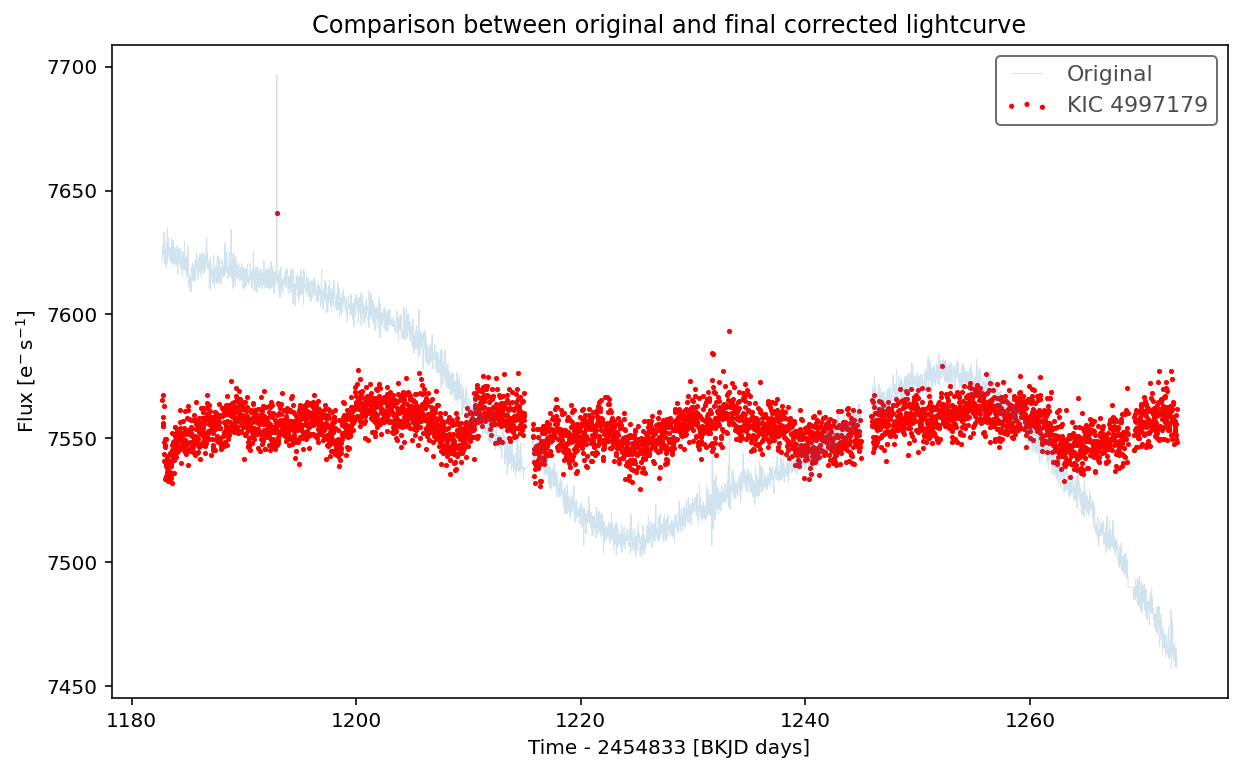

13


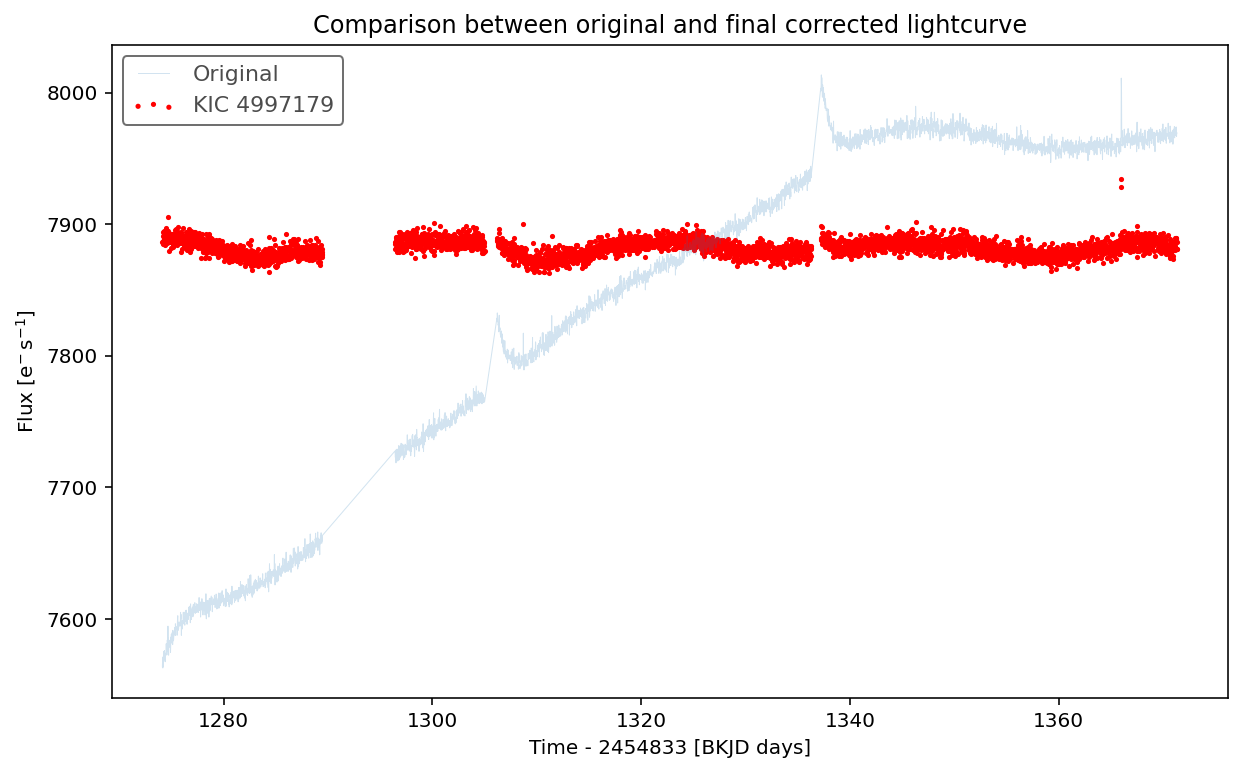

14


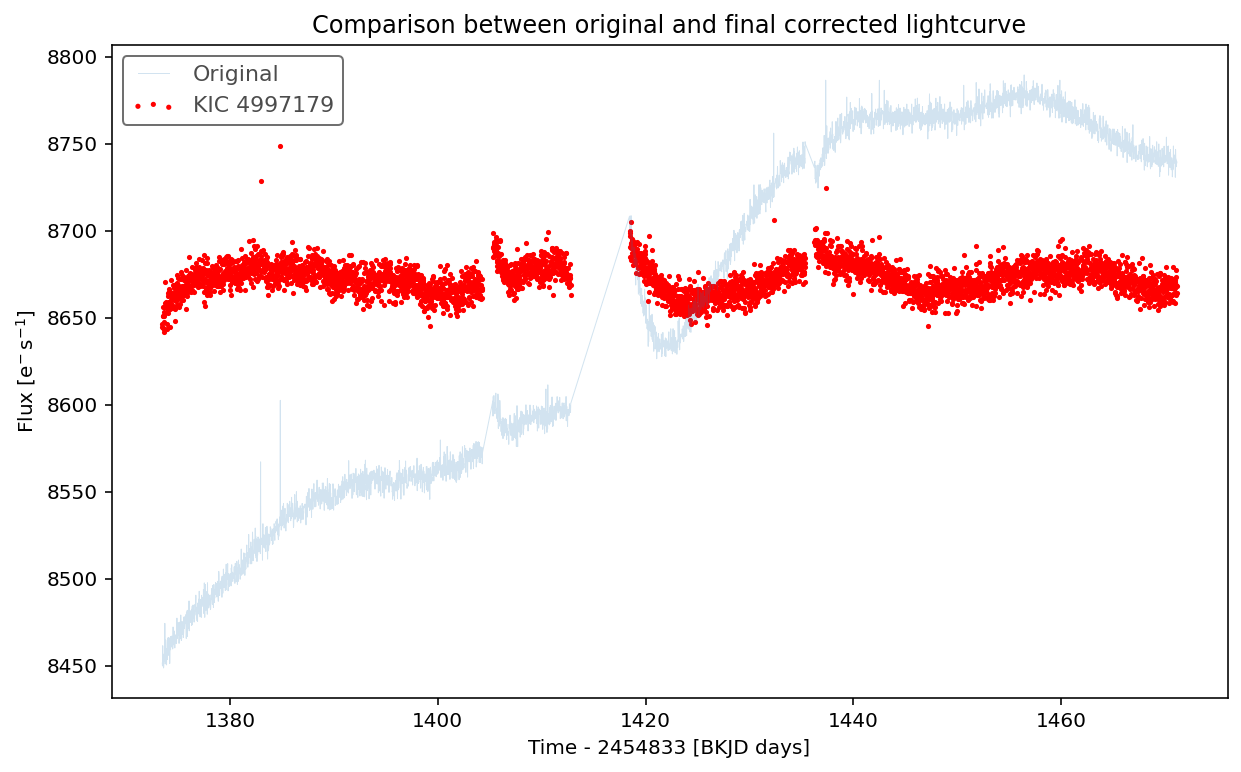

15


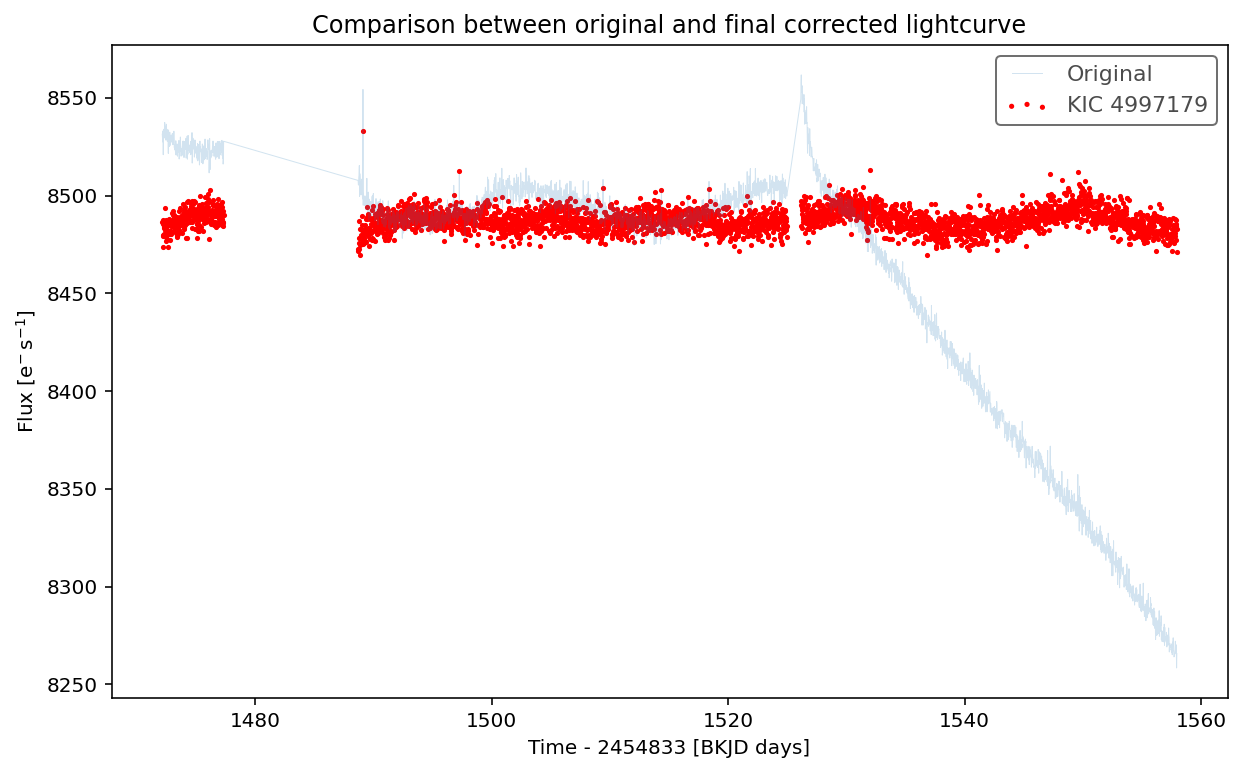

16


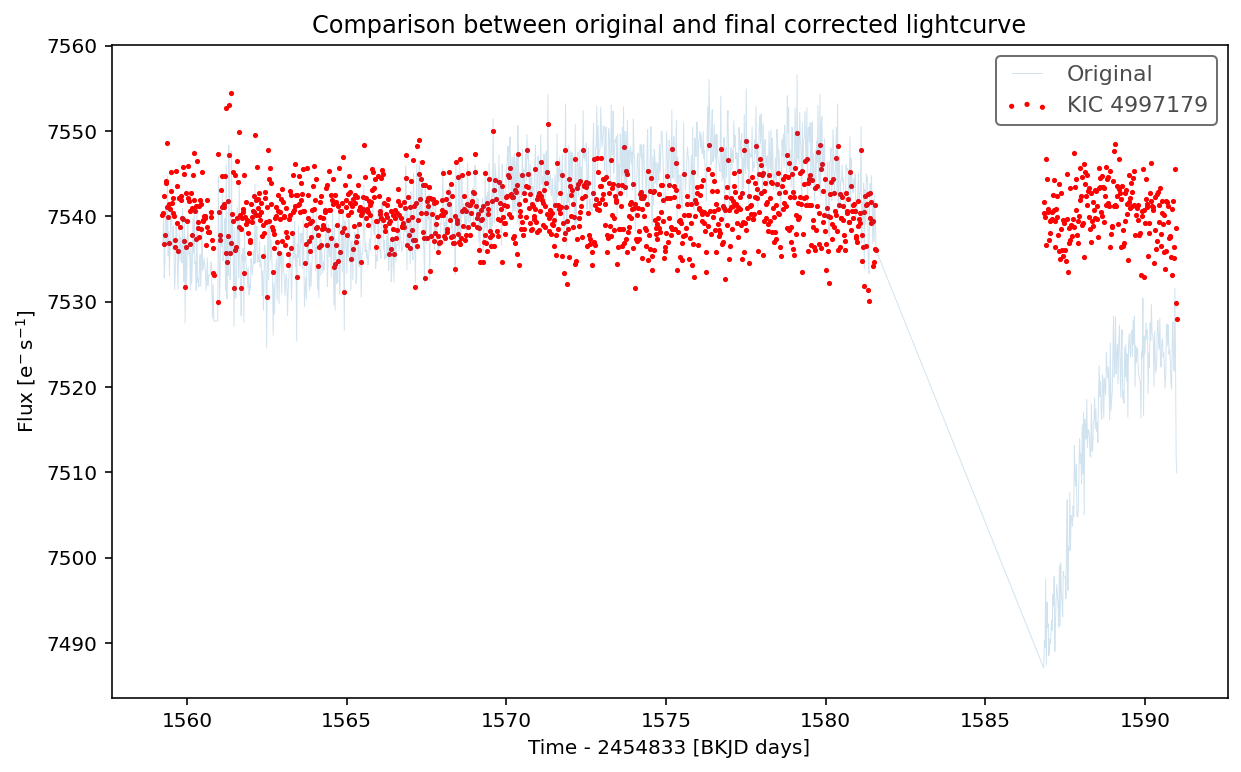

In [127]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9)]
# Perform the correction



for i in range(len(lcs)):
    print(i)
    
    cbvCorrector[i].correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)

    #cbvCorrector[i].correct(cbv_type=cbv_type, cbv_indices=cbv_indices);
    #cbvCorrector[i].diagnose();
    #cbvCorrector[i].goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

    #cbvCorrector[i].correct(cbv_type=cbv_type,
    #                     cbv_indices=cbv_indices, 
    #                     target_over_score=0.9,
    #                     target_under_score=0.5)
    #cbvCorrector[i].diagnose();
    #cbvCorrector[i].goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);
    
    # Fit to the Multi-Scale Band 2 CBVs with ElasticNet to add in a L1-Norm (Lasso) term
    cbvCorrector[i].correct_elasticnet(cbv_type=['SingleScale'], cbv_indices=[np.arange(1,9)], alpha=1.0e-7, l1_ratio=0.5)
    #ax = cbvCorrector[i].diagnose()
    #ax[0].set_title('Result of First Correction to SingleScale.2 CBVs');

    # Plot the final correction
    _, ax = plt.subplots(1, figsize=(10, 6))
    cbvCorrector[i].lc.plot(ax=ax, normalize=False, alpha=0.2, label='Original')
    cbvCorrector[i].corrected_lc.scatter(normalize=False, c='r', marker='.',
                                                s=10, ax=ax)
    ax.set_title('Comparison between original and final corrected lightcurve');
    
    ax.plot()
    plt.show()

In [128]:
lcs_final = LightCurveCollection([cbvCorrector[i].corrected_lc for i in range(len(lcs))])
lc_final = lcs_final.stitch()

(0.99, 1.01)

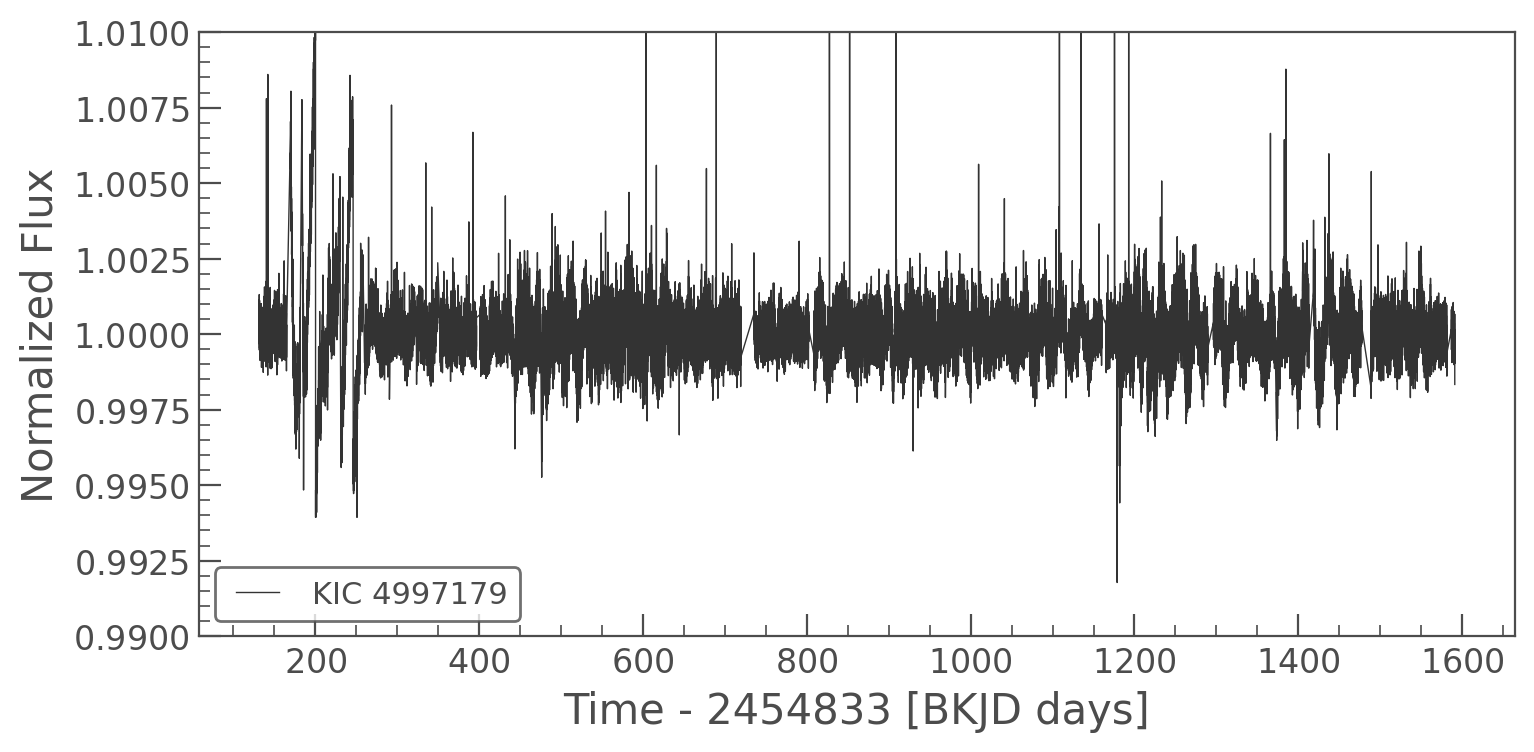

In [129]:
lc_final.plot()

#plt.xlim(1300,1600)

plt.ylim(0.99, 1.01)

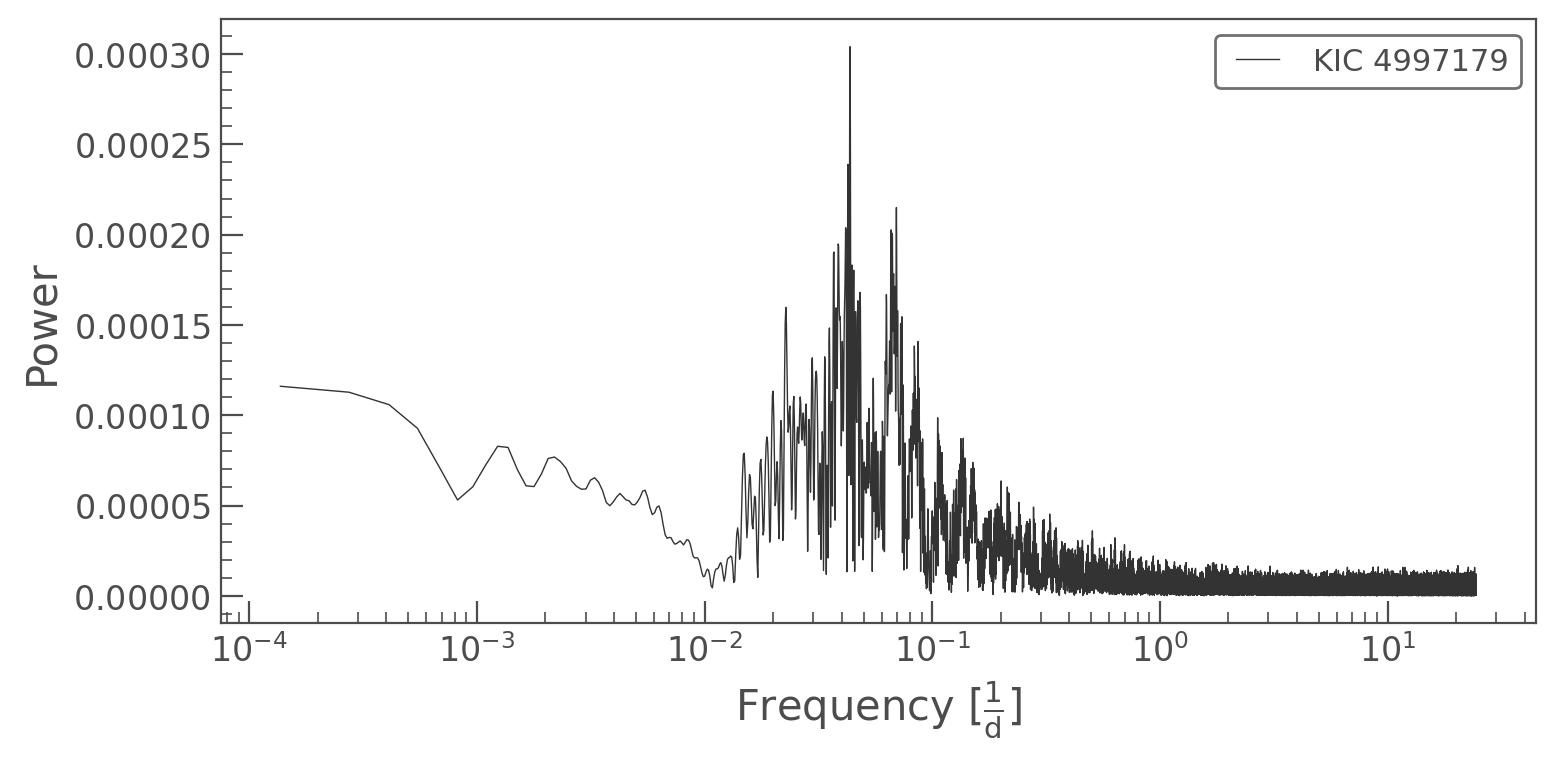

22.947939740986257 d


In [130]:
pg = lc_final.to_periodogram()
ax = pg.plot()
ax.set_xscale('log')
plt.show()

print(pg.period_at_max_power)

Let's add in the FFI data

In [131]:
times = np.array([54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,
                  54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,
                  55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,
                  55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,
                  55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,
                  55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,
                  55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
                  56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,
                  56303.6729488,56330.563549,56357.495041,56390.4952381])

ffidata = pd.read_csv('../../data/f3/lc_data_new.out')

In [132]:
times_bkjd = times + 2400000.5 - 2454833.0

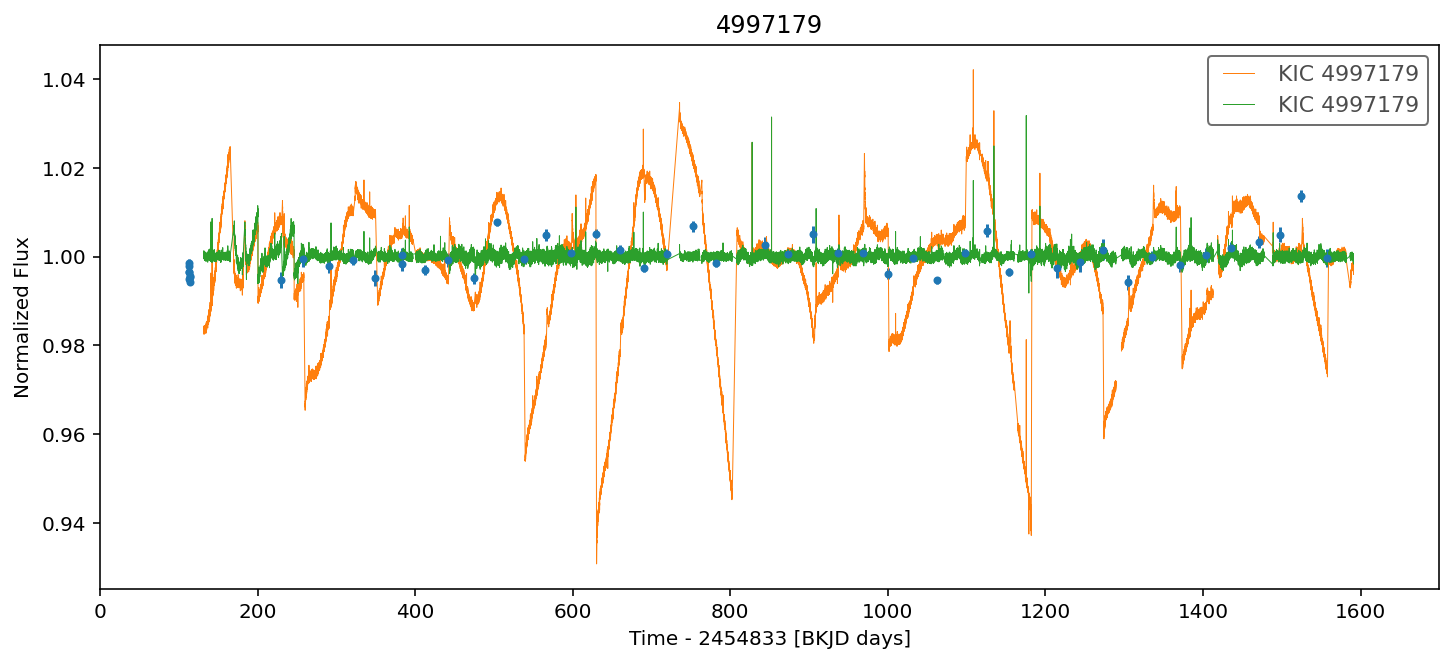

In [135]:
flux = ffidata[ffidata['KIC'] == int(kepid)].iloc[:,1:53]
yerr = ffidata[ffidata['KIC'] == int(kepid)].iloc[:,-52:]

fig, ax = plt.subplots(figsize=(12,5))
ax.errorbar(times-54833, np.asarray(flux)[0], yerr=np.asarray(yerr)[0], fmt='.')
ax.set_xlabel('Time')
ax.set_ylabel('Normalised Flux')
ax.set_title(kepid)

lc.plot(ax=ax)
lc_final.plot(ax=ax)

ax.set_xlim(0,1700);

In [138]:
len(lc.time)

65031